# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

In [1]:
import json
import pandas as pd
from decimal import Decimal

from matplotlib import pyplot as plt

# DataFrame analyses
from src.DataFrameAnalyses import DataFramePlotGenerator, DataFrameChecker, DataFrameMetricsAnalyser

# Analysis utils
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.CP_Solver import Solver

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Database and Collections
from src.domain.Query import JobQuery, MachineQuery
from src.domain.Collection import LiveJobCollection

In [3]:
# Hard termination condition for schedulers
max_time = 60*10     # 10 min

# File paths
examples_data_path = get_path("data", "examples")
logs_path = get_path("data", "logs")

# Simulation
simulation = ProductionSimulation(shift_length= 1440, sigma = 0.2)

In [4]:
# Jobs for 20 days (shifts)
timespan = 60*24*20

jobs = JobQuery.get_by_source_name_max_util_and_lt_arrival(
    source_name="Fisher and Thompson 10x10",
    max_bottleneck_utilization = Decimal("0.85"),
    arrival_limit= timespan
)
#jobs = [job for job in all_jobs if job.earliest_start <=timespan]

jobs_collection = LiveJobCollection(jobs)
jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,1440,2746
1,01-08500-0001,01-06,53,1440,2759
2,01-08500-0002,01-01,125,1440,2835
3,01-08500-0003,01-05,174,1440,3912
4,01-08500-0004,01-04,219,1440,3628
5,01-08500-0005,01-02,443,1440,3168
...,...,...,...,...,...
370,01-08500-0370,01-03,28563,28800,29964
371,01-08500-0371,01-00,28671,28800,29953
372,01-08500-0372,01-07,28737,28800,30839


In [5]:
for job in list(jobs_collection.values())[:2]:
    print(f"{job.id = }")
    for operation in job.operations:
        print(f" {operation.position_number = } {operation.machine_name = } {operation.transition_time = }")

job.id = '01-08500-0000'
 operation.position_number = 0 operation.machine_name = 'M02' operation.transition_time = 0
 operation.position_number = 1 operation.machine_name = 'M00' operation.transition_time = 0
 operation.position_number = 2 operation.machine_name = 'M01' operation.transition_time = 0
 operation.position_number = 3 operation.machine_name = 'M05' operation.transition_time = 0
 operation.position_number = 4 operation.machine_name = 'M04' operation.transition_time = 0
 operation.position_number = 5 operation.machine_name = 'M06' operation.transition_time = 0
 operation.position_number = 6 operation.machine_name = 'M08' operation.transition_time = 0
 operation.position_number = 7 operation.machine_name = 'M09' operation.transition_time = 0
 operation.position_number = 8 operation.machine_name = 'M07' operation.transition_time = 0
 operation.position_number = 9 operation.machine_name = 'M03' operation.transition_time = 0
job.id = '01-08500-0001'
 operation.position_number = 0

In [6]:
machines = MachineQuery.get_machines(
    source_name="Fisher and Thompson 10x10",
    max_bottleneck_utilization=Decimal("0.90")
)

for machine in machines:
    print(machine)

Machine(id=31, source_id=1, name='M00', max_bottleneck_utilization=Decimal('0.9000'), transition_time=247)
Machine(id=32, source_id=1, name='M01', max_bottleneck_utilization=Decimal('0.9000'), transition_time=533)
Machine(id=33, source_id=1, name='M02', max_bottleneck_utilization=Decimal('0.9000'), transition_time=156)
Machine(id=34, source_id=1, name='M03', max_bottleneck_utilization=Decimal('0.9000'), transition_time=279)
Machine(id=35, source_id=1, name='M04', max_bottleneck_utilization=Decimal('0.9000'), transition_time=79)
Machine(id=36, source_id=1, name='M05', max_bottleneck_utilization=Decimal('0.9000'), transition_time=97)
Machine(id=37, source_id=1, name='M06', max_bottleneck_utilization=Decimal('0.9000'), transition_time=56)
Machine(id=38, source_id=1, name='M07', max_bottleneck_utilization=Decimal('0.9000'), transition_time=95)
Machine(id=39, source_id=1, name='M08', max_bottleneck_utilization=Decimal('0.9000'), transition_time=82)
Machine(id=40, source_id=1, name='M09', ma

### Add transition times to operations (not saved in DB)

In [7]:
for machine in machines:
    for job in jobs_collection.values():
        for operation in job.operations:
            if operation.machine_name == machine.name:
                operation.transition_time = machine.transition_time
                # break # if sure that machines do not repeat per job

In [8]:
for job in list(jobs_collection.values())[:2]:
    print(job.id)
    for operation in job.operations:
        print(f" {operation.position_number = } {operation.machine_name = } {operation.transition_time = }")

01-08500-0000
 operation.position_number = 0 operation.machine_name = 'M02' operation.transition_time = 156
 operation.position_number = 1 operation.machine_name = 'M00' operation.transition_time = 247
 operation.position_number = 2 operation.machine_name = 'M01' operation.transition_time = 533
 operation.position_number = 3 operation.machine_name = 'M05' operation.transition_time = 97
 operation.position_number = 4 operation.machine_name = 'M04' operation.transition_time = 79
 operation.position_number = 5 operation.machine_name = 'M06' operation.transition_time = 56
 operation.position_number = 6 operation.machine_name = 'M08' operation.transition_time = 82
 operation.position_number = 7 operation.machine_name = 'M09' operation.transition_time = 25
 operation.position_number = 8 operation.machine_name = 'M07' operation.transition_time = 95
 operation.position_number = 9 operation.machine_name = 'M03' operation.transition_time = 279
01-08500-0001
 operation.position_number = 0 operati

## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [9]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [10]:
# New jobs that must be scheduled
current_jobs_collection = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)


In [11]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,M02,None,31,None,0,1440,2746
1,01-08500-0000,01-07,1,M00,None,86,None,0,1440,2746
2,01-08500-0000,01-07,2,M01,None,46,None,0,1440,2746
3,01-08500-0000,01-07,3,M05,None,74,None,0,1440,2746
4,01-08500-0000,01-07,4,M04,None,32,None,0,1440,2746
5,01-08500-0000,01-07,5,M06,None,88,None,0,1440,2746
...,...,...,...,...,...,...,...,...,...,...
154,01-08500-0015,01-01,4,M03,None,69,None,1437,1440,3089
155,01-08500-0015,01-01,5,M01,None,28,None,1437,1440,3089
156,01-08500-0015,01-01,6,M06,None,46,None,1437,1440,3089


In [12]:
df_jobs_times_current = current_jobs_collection.to_jobs_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,1440,2746
1,01-08500-0001,01-06,53,1440,2759
2,01-08500-0002,01-01,125,1440,2835
3,01-08500-0003,01-05,174,1440,3912
4,01-08500-0004,01-04,219,1440,3628
5,01-08500-0005,01-02,443,1440,3168
6,01-08500-0006,01-00,753,1440,3570
7,01-08500-0007,01-03,896,1440,3379
8,01-08500-0008,01-09,962,1440,2689
9,01-08500-0009,01-08,979,1440,3402


### Scheduling

In [13]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)
solver.build_model_for_jssp_lateness_with_start_deviation_minimization_with_transition_times(
    previous_schedule_jobs_collection=None,
    active_jobs_collection=None,
    w_t = 5, w_e = 1
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

JobOperation(job_id='01-08500-0000', position_number=0, machine_name='M02', duration=31) operation.job.earliest_start = 1440 | reasonable_min_start = 993 due_date = 2746 - duration = 539, - left_transition_time = 1214
JobOperation(job_id='01-08500-0001', position_number=0, machine_name='M01', duration=46) operation.job.earliest_start = 1440 | reasonable_min_start = 1306 due_date = 2759 - duration = 416, - left_transition_time = 1037
JobOperation(job_id='01-08500-0002', position_number=0, machine_name='M00', duration=43) operation.job.earliest_start = 1440 | reasonable_min_start = 1005 due_date = 2835 - duration = 510, - left_transition_time = 1320
JobOperation(job_id='01-08500-0003', position_number=0, machine_name='M02', duration=84) operation.job.earliest_start = 1440 | reasonable_min_start = 2018 due_date = 3912 - duration = 496, - left_transition_time = 1398
JobOperation(job_id='01-08500-0004', position_number=0, machine_name='M02', duration=14) operation.job.earliest_start = 1440 

In [14]:
log_file_path = logs_path / "cp_lateness_with_transition_times_init.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

{
  "status": "OPTIMAL",
  "objective_value": 0.0,
  "best_objective_bound": 0.0,
  "number_of_branches": 58,
  "wall_time": 0.04
}


In [15]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,M02,1440,31,1471,0,1440,2746
1,01-08500-0000,01-07,1,M00,1483,86,1569,0,1440,2746
2,01-08500-0000,01-07,2,M01,1662,46,1708,0,1440,2746
3,01-08500-0000,01-07,3,M05,1708,74,1782,0,1440,2746
4,01-08500-0000,01-07,4,M04,1782,32,1814,0,1440,2746
5,01-08500-0000,01-07,5,M06,1814,88,1902,0,1440,2746
...,...,...,...,...,...,...,...,...,...,...
154,01-08500-0015,01-01,4,M03,2096,69,2165,1437,1440,3089
155,01-08500-0015,01-01,5,M01,2192,28,2220,1437,1440,3089
156,01-08500-0015,01-01,6,M06,2231,46,2277,1437,1440,3089


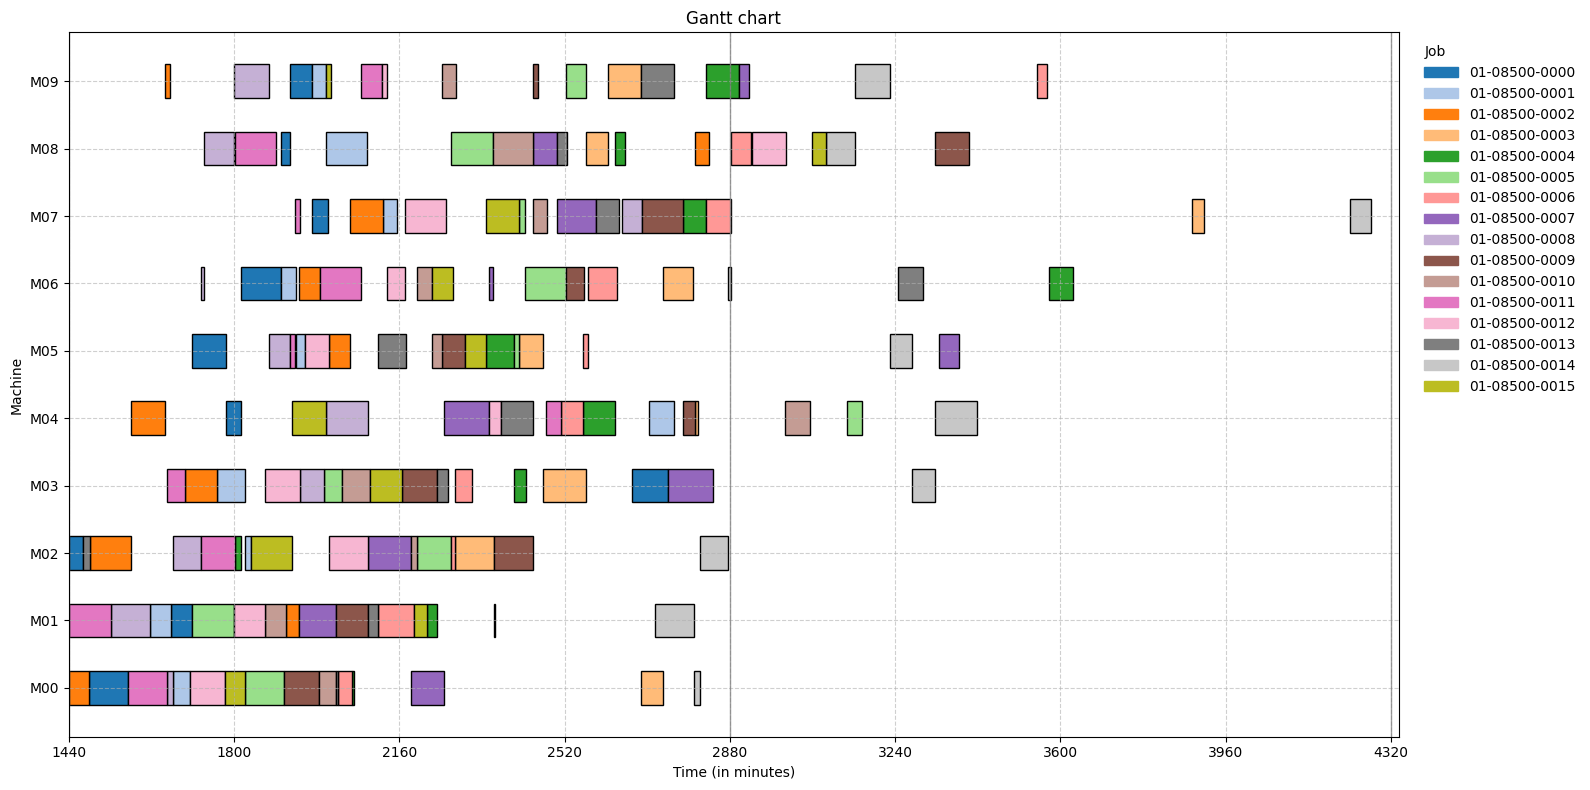

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [16]:
DataFramePlotGenerator.get_gantt_chart_figure(df_schedule, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_schedule)
DataFrameChecker.is_duration_correct(df_schedule)


In [17]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
df_jobs_metrics

,Job,Routing_ID,Last Operation,End,Arrival,Ready Time,Due Date,Total Processing Time,Flowtime,Lateness,Tardiness,Earliness
0,01-08500-0000,01-07,9,2746,0,1440,2746,539,1306,0,0,0
1,01-08500-0001,01-06,9,2759,53,1440,2759,416,1319,0,0,0
2,01-08500-0002,01-01,9,2835,125,1440,2835,510,1395,0,0,0
3,01-08500-0003,01-05,9,3912,174,1440,3912,496,2472,0,0,0
4,01-08500-0004,01-04,9,3628,219,1440,3628,393,2188,0,0,0
5,01-08500-0005,01-02,9,3168,443,1440,3168,568,1728,0,0,0
6,01-08500-0006,01-00,9,3570,753,1440,3570,395,2130,0,0,0
7,01-08500-0007,01-03,9,3379,896,1440,3379,655,1939,0,0,0
8,01-08500-0008,01-09,9,2689,962,1440,2689,540,1249,0,0,0
9,01-08500-0009,01-08,9,3402,979,1440,3402,597,1962,0,0,0


In [18]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,16,0,0,0


In [19]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,0,16,0,0,0


### Simulation

In [20]:
# simulation.run(schedule_collection = schedule_jobs_collection, start_time = day_start, end_time=day_end)
simulation.initialize_run(schedule_collection = schedule_jobs_collection, start_time=day_start)

[Day 1 00:00:00] Job 01-08500-0000 started on M02
[Day 1 00:00:00] Job 01-08500-0002 started on M00
[Day 1 00:00:00] Job 01-08500-0011 started on M01
[Day 1 00:31:00] Job 01-08500-0000 finished on M02 (after 31 minutes)
[Day 1 00:31:00] Job 01-08500-0013 started on M02
[Day 1 00:37:00] Job 01-08500-0002 finished on M00 (after 37 minutes)
[Day 1 00:43:00] Job 01-08500-0013 finished on M02 (after 12 minutes)
[Day 1 00:43:00] Job 01-08500-0000 started on M00
[Day 1 00:45:00] Job 01-08500-0002 started on M02
[Day 1 01:29:00] Job 01-08500-0011 finished on M01 (after 89 minutes)
[Day 1 01:31:00] Job 01-08500-0008 started on M01
[Day 1 01:49:00] Job 01-08500-0002 finished on M02 (after 64 minutes)
[Day 1 02:15:00] Job 01-08500-0002 started on M04
[Day 1 02:32:00] Job 01-08500-0000 finished on M00 (after 109 minutes)
[Day 1 02:32:00] Job 01-08500-0011 started on M00
[Day 1 03:13:00] Job 01-08500-0008 finished on M01 (after 102 minutes)
[Day 1 03:13:00] Job 01-08500-0001 started on M01
[Day 1 0

In [21]:
finished_job_ops_collection = simulation.get_finished_operation_collection()
df_execution = finished_job_ops_collection.to_operations_dataframe()
df_execution

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0000,01-07,0,M02,1440.0,31.0,1471.0,0,1440,2746
1,01-08500-0000,01-07,1,M00,1483.0,109.0,1592.0,0,1440,2746
2,01-08500-0000,01-07,2,M01,1710.0,42.0,1752.0,0,1440,2746
3,01-08500-0000,01-07,3,M05,1752.0,70.0,1822.0,0,1440,2746
4,01-08500-0000,01-07,4,M04,1822.0,24.0,1846.0,0,1440,2746
5,01-08500-0000,01-07,5,M06,1846.0,102.0,1948.0,0,1440,2746
...,...,...,...,...,...,...,...,...,...,...
131,01-08500-0003,01-05,4,M08,2673.0,47.0,2720.0,174,1440,3912
132,01-08500-0003,01-05,5,M09,2749.0,68.0,2817.0,174,1440,3912
133,01-08500-0003,01-05,6,M00,2817.0,44.0,2861.0,174,1440,3912


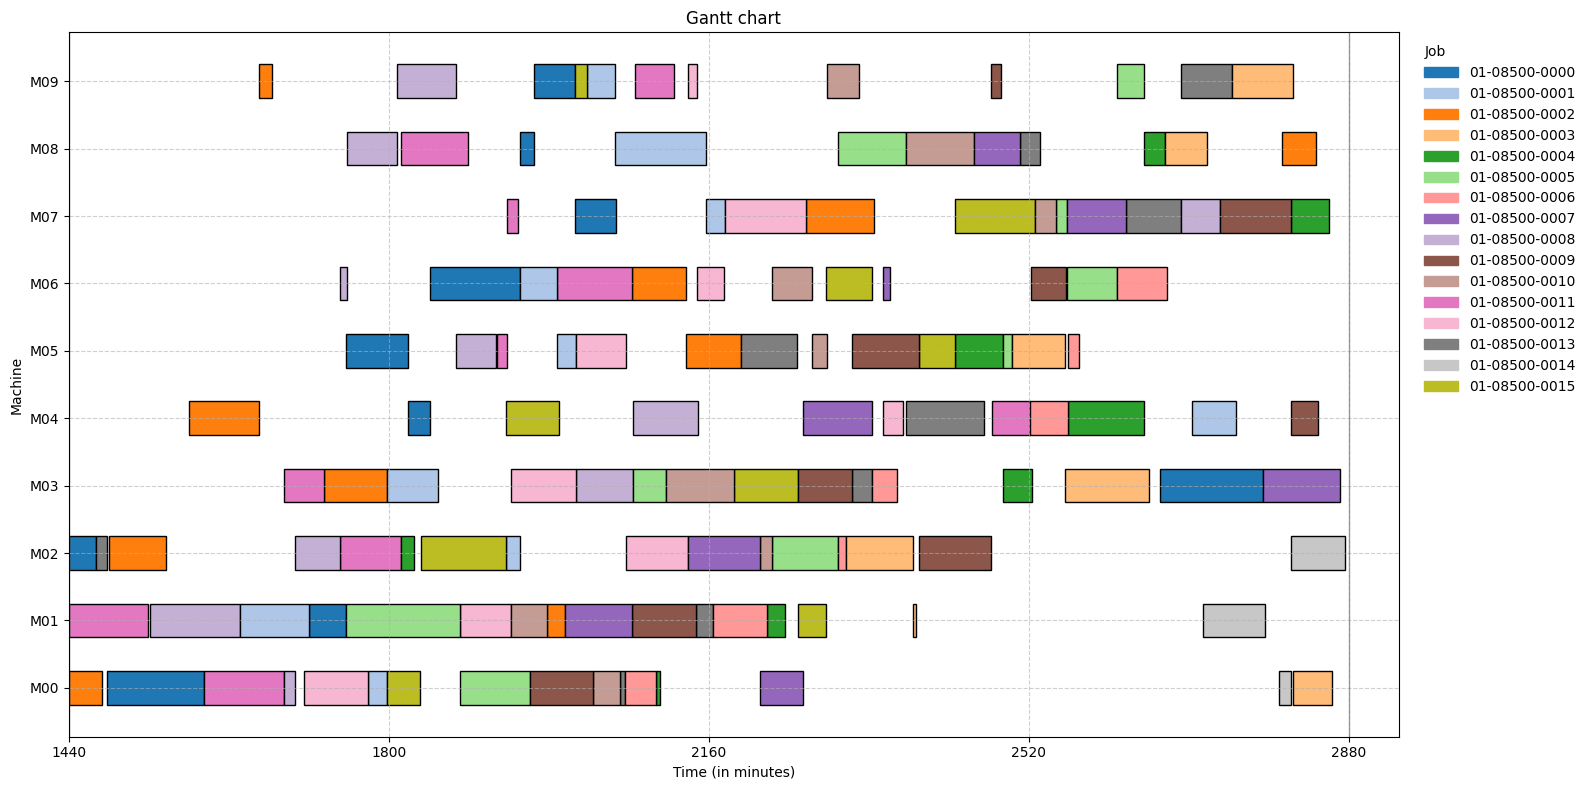

In [22]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution, perspective="Machine")
plt.show()

In [23]:
active_job_ops_collection = simulation.get_active_operation_collection()
df_active = active_job_ops_collection.to_operations_dataframe()
df_active

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0006,01-00,7,M07,2858.0,54.0,2912.0,753,1440,3570
1,01-08500-0004,01-04,8,M09,2858.0,65.0,2923.0,219,1440,3628
2,01-08500-0003,01-05,7,M06,2861.0,77.0,2938.0,174,1440,3912


In [24]:
waiting_job_ops_collection = simulation.get_waiting_operation_collection()
waiting_job_ops_collection.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,8,M04,2804,6,2810,174,1440,3912
1,01-08500-0003,01-05,9,M07,3887,25,3912,174,1440,3912
2,01-08500-0004,01-04,9,M06,3575,53,3628,219,1440,3628
3,01-08500-0005,01-02,9,M04,3135,33,3168,443,1440,3168
4,01-08500-0006,01-00,8,M08,2883,44,2927,753,1440,3570
5,01-08500-0006,01-00,9,M09,3549,21,3570,753,1440,3570
...,...,...,...,...,...,...,...,...,...,...
14,01-08500-0014,01-09,5,M09,3153,76,3229,1210,1440,4277
15,01-08500-0014,01-09,6,M05,3229,47,3276,1210,1440,4277
16,01-08500-0014,01-09,7,M03,3276,52,3328,1210,1440,4277


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [25]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [26]:
# New and previous jobs that must be scheduled
current_jobs_collection_temp = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)
current_jobs_collection = current_jobs_collection_temp + waiting_job_ops_collection

In [27]:
# Test
current_jobs_collection_temp.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0016,01-07,0,M02,None,31,None,1504,2880,4447
1,01-08500-0016,01-07,1,M00,None,86,None,1504,2880,4447
2,01-08500-0016,01-07,2,M01,None,46,None,1504,2880,4447
3,01-08500-0016,01-07,3,M05,None,74,None,1504,2880,4447
4,01-08500-0016,01-07,4,M04,None,32,None,1504,2880,4447
5,01-08500-0016,01-07,5,M06,None,88,None,1504,2880,4447
...,...,...,...,...,...,...,...,...,...,...
204,01-08500-0036,01-03,4,M06,None,9,None,2811,2880,4882
205,01-08500-0036,01-03,5,M08,None,52,None,2811,2880,4882
206,01-08500-0036,01-03,6,M07,None,85,None,2811,2880,4882


In [28]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,8,M04,2804.0,6,2810.0,174,1440,3912
1,01-08500-0003,01-05,9,M07,3887.0,25,3912.0,174,1440,3912
2,01-08500-0004,01-04,9,M06,3575.0,53,3628.0,219,1440,3628
3,01-08500-0005,01-02,9,M04,3135.0,33,3168.0,443,1440,3168
4,01-08500-0006,01-00,8,M08,2883.0,44,2927.0,753,1440,3570
5,01-08500-0006,01-00,9,M09,3549.0,21,3570.0,753,1440,3570
...,...,...,...,...,...,...,...,...,...,...
224,01-08500-0036,01-03,4,M06,NaN,9,NaN,2811,2880,4882
225,01-08500-0036,01-03,5,M08,NaN,52,NaN,2811,2880,4882
226,01-08500-0036,01-03,6,M07,NaN,85,NaN,2811,2880,4882


### Scheduling (Rescheduling)

In [29]:
previous_schedule_jobs_collection = schedule_jobs_collection
df_previous_schedule = previous_schedule_jobs_collection.to_operations_dataframe()

#### a) Simple Scheduling

In [30]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)

solver.build_model_for_jssp_lateness_with_start_deviation_minimization_with_transition_times(
    previous_schedule_jobs_collection=None,         # simple scheduling
    active_jobs_collection=active_job_ops_collection,
    w_t = 5, w_e = 1
)
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

log_file_path = logs_path / "cp_lateness_with_transition_times_2_simple.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))


JobOperation(job_id='01-08500-0016', position_number=0, machine_name='M02', duration=31) operation.job.earliest_start = 2880 | reasonable_min_start = 2694 due_date = 4447 - duration = 539, - left_transition_time = 1214
JobOperation(job_id='01-08500-0017', position_number=0, machine_name='M02', duration=84) operation.job.earliest_start = 2880 | reasonable_min_start = 2360 due_date = 4254 - duration = 496, - left_transition_time = 1398
JobOperation(job_id='01-08500-0018', position_number=0, machine_name='M01', duration=81) operation.job.earliest_start = 2880 | reasonable_min_start = 3095 due_date = 4769 - duration = 655, - left_transition_time = 1019
JobOperation(job_id='01-08500-0019', position_number=0, machine_name='M00', duration=29) operation.job.earliest_start = 2880 | reasonable_min_start = 2926 due_date = 4698 - duration = 395, - left_transition_time = 1377
JobOperation(job_id='01-08500-0020', position_number=0, machine_name='M02', duration=84) operation.job.earliest_start = 2880

In [31]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_02_simple.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,8,M04,2938,6,2944,174,1440,3912
1,01-08500-0003,01-05,9,M07,3887,25,3912,174,1440,3912
2,01-08500-0004,01-04,9,M06,3575,53,3628,219,1440,3628
3,01-08500-0005,01-02,9,M04,3135,33,3168,443,1440,3168
4,01-08500-0006,01-00,8,M08,3003,44,3047,753,1440,3570
5,01-08500-0006,01-00,9,M09,3549,21,3570,753,1440,3570
...,...,...,...,...,...,...,...,...,...,...
224,01-08500-0036,01-03,4,M06,3554,9,3563,2811,2880,4882
225,01-08500-0036,01-03,5,M08,3563,52,3615,2811,2880,4882
226,01-08500-0036,01-03,6,M07,3615,85,3700,2811,2880,4882


In [32]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 4 (over 18 shared operations)
Mean Kendall Tau: 0.69


In [33]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,1,31,0,0,0


### b) with 'start' deviation penalty

In [53]:
solver = Solver(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start
)

solver.build_model_for_jssp_lateness_with_start_deviation_minimization_with_transition_times(
    previous_schedule_jobs_collection=previous_schedule_jobs_collection,
    active_jobs_collection=active_job_ops_collection,
    w_t = 2, w_e = 1, w_dev = 5
)

model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

log_file_path = logs_path / "cp_lateness_with_w_first_2_dev.log"

solver.solve_model(
    log_file= log_file_path,
    gap_limit= 0.00,
    time_limit= max_time
)
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

JobOperation(job_id='01-08500-0016', position_number=0, machine_name='M02', duration=31) operation.job.earliest_start = 2880 | reasonable_min_start = 2694 due_date = 4447 - duration = 539, - left_transition_time = 1214
JobOperation(job_id='01-08500-0017', position_number=0, machine_name='M02', duration=84) operation.job.earliest_start = 2880 | reasonable_min_start = 2360 due_date = 4254 - duration = 496, - left_transition_time = 1398
JobOperation(job_id='01-08500-0018', position_number=0, machine_name='M01', duration=81) operation.job.earliest_start = 2880 | reasonable_min_start = 3095 due_date = 4769 - duration = 655, - left_transition_time = 1019
JobOperation(job_id='01-08500-0019', position_number=0, machine_name='M00', duration=29) operation.job.earliest_start = 2880 | reasonable_min_start = 2926 due_date = 4698 - duration = 395, - left_transition_time = 1377
JobOperation(job_id='01-08500-0020', position_number=0, machine_name='M02', duration=84) operation.job.earliest_start = 2880

In [54]:
schedule_jobs_collection = solver.get_schedule()
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_02_dev.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-08500-0003,01-05,8,M04,2938,6,2944,174,1440,3912
1,01-08500-0003,01-05,9,M07,3887,25,3912,174,1440,3912
2,01-08500-0004,01-04,9,M06,3575,53,3628,219,1440,3628
3,01-08500-0005,01-02,9,M04,3135,33,3168,443,1440,3168
4,01-08500-0006,01-00,8,M08,2912,44,2956,753,1440,3570
5,01-08500-0006,01-00,9,M09,3549,21,3570,753,1440,3570
...,...,...,...,...,...,...,...,...,...,...
224,01-08500-0036,01-03,4,M06,3554,9,3563,2811,2880,4882
225,01-08500-0036,01-03,5,M08,3563,52,3615,2811,2880,4882
226,01-08500-0036,01-03,6,M07,3615,85,3700,2811,2880,4882


In [55]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

,Original Sequence,Revised Sequence,Levenshtein,Kendall Tau
Machine,,,,
M03,[01-08500-0014],[01-08500-0014],0,1.0
M04,"[01-08500-0010, 01-08500-0005, 01-08500-0014]","[01-08500-0010, 01-08500-0005, 01-08500-0014]",0,1.0
M05,"[01-08500-0014, 01-08500-0007]","[01-08500-0014, 01-08500-0007]",0,1.0
M06,"[01-08500-0013, 01-08500-0004]","[01-08500-0013, 01-08500-0004]",0,1.0
M07,"[01-08500-0003, 01-08500-0014]","[01-08500-0003, 01-08500-0014]",0,1.0
M08,"[01-08500-0006, 01-08500-0012, 01-08500-0015, ...","[01-08500-0006, 01-08500-0012, 01-08500-0015, ...",0,1.0
M09,"[01-08500-0007, 01-08500-0014, 01-08500-0006]","[01-08500-0007, 01-08500-0014, 01-08500-0006]",0,1.0


In [56]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 0 (over 18 shared operations)
Mean Kendall Tau: 1.00


In [57]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,1,30,1,0,0


#### Check the conditions of the combined data set from the simulation data with the new schedule

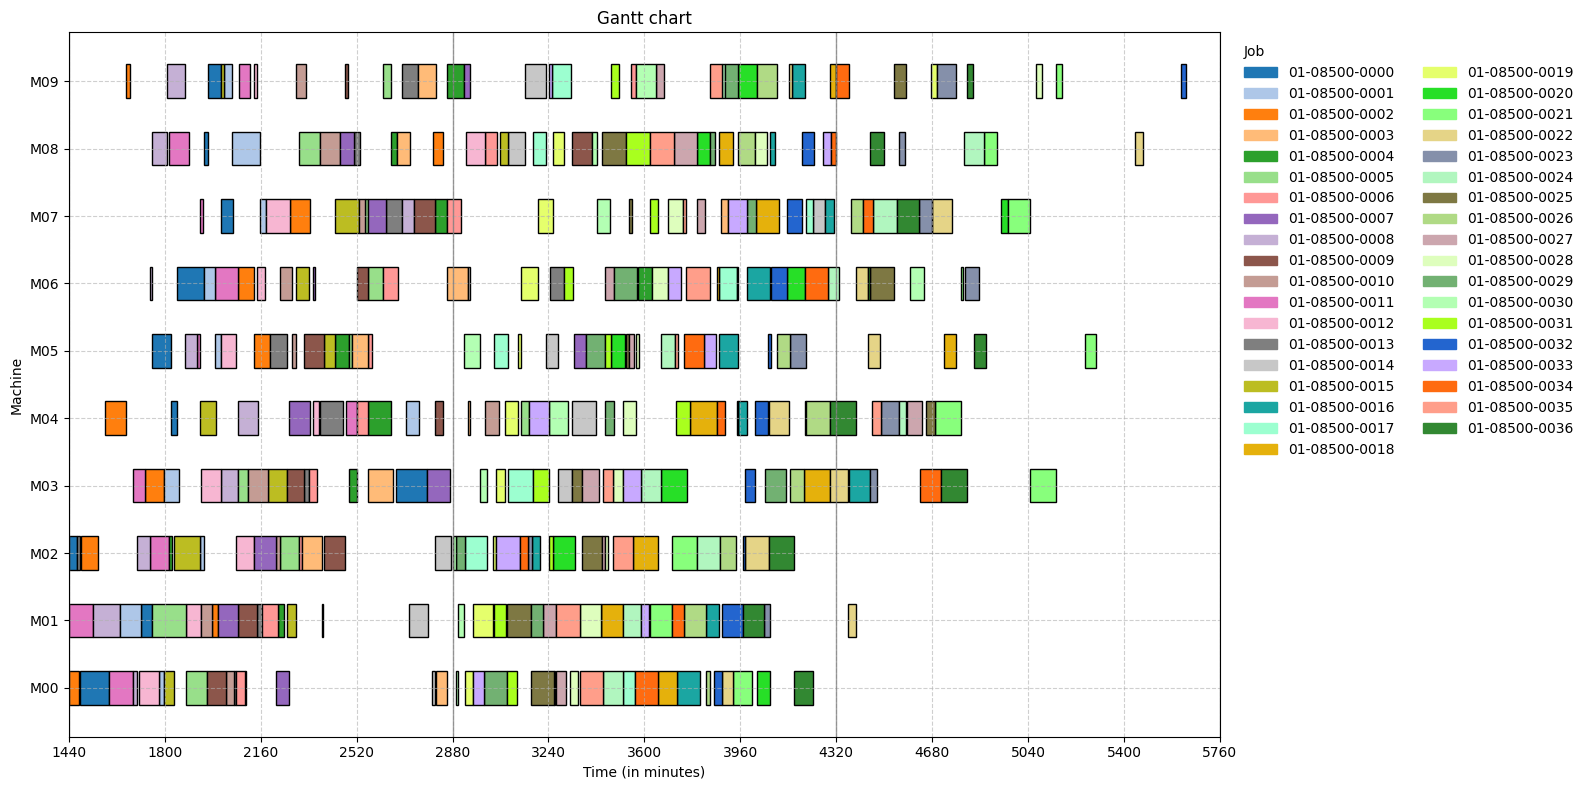

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [39]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)

### Simulation

In [40]:
simulation.run(schedule_collection=schedule_jobs_collection, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job 01-08500-0006, Operation 7 resumed on M07 with 32 minutes left)
[Day 2 00:00:00] Job 01-08500-0004, Operation 8 resumed on M09 with 43 minutes left)
[Day 2 00:00:00] Job 01-08500-0003, Operation 7 resumed on M06 with 58 minutes left)
[Day 2 00:00:00] Job 01-08500-0030 started on M02
[Day 2 00:15:00] Job 01-08500-0030 finished on M02 (after 15 minutes)
[Day 2 00:15:00] Job 01-08500-0029 started on M02
[Day 2 00:15:00] Job 01-08500-0030 started on M00
[Day 2 00:21:00] Job 01-08500-0030 finished on M00 (after 06 minutes)
[Day 2 00:21:00] Job 01-08500-0030 started on M01
[Day 2 00:32:00] Job 01-08500-0006 finished on M07 (after 32 minutes)
[Day 2 00:43:00] Job 01-08500-0004 finished on M09 (after 43 minutes)
[Day 2 00:43:00] Job 01-08500-0007 started on M09
[Day 2 00:45:00] Job 01-08500-0030 finished on M01 (after 24 minutes)
[Day 2 00:45:00] Job 01-08500-0030 started on M05
[Day 2 00:46:00] Job 01-08500-0019 started on M00
[Day 2 00:49:00] Job 01-08500-0012 started on

In [41]:
finished_job_ops_collection2 = simulation.get_finished_operation_collection()
df_execution2 = finished_job_ops_collection2.to_operations_dataframe()

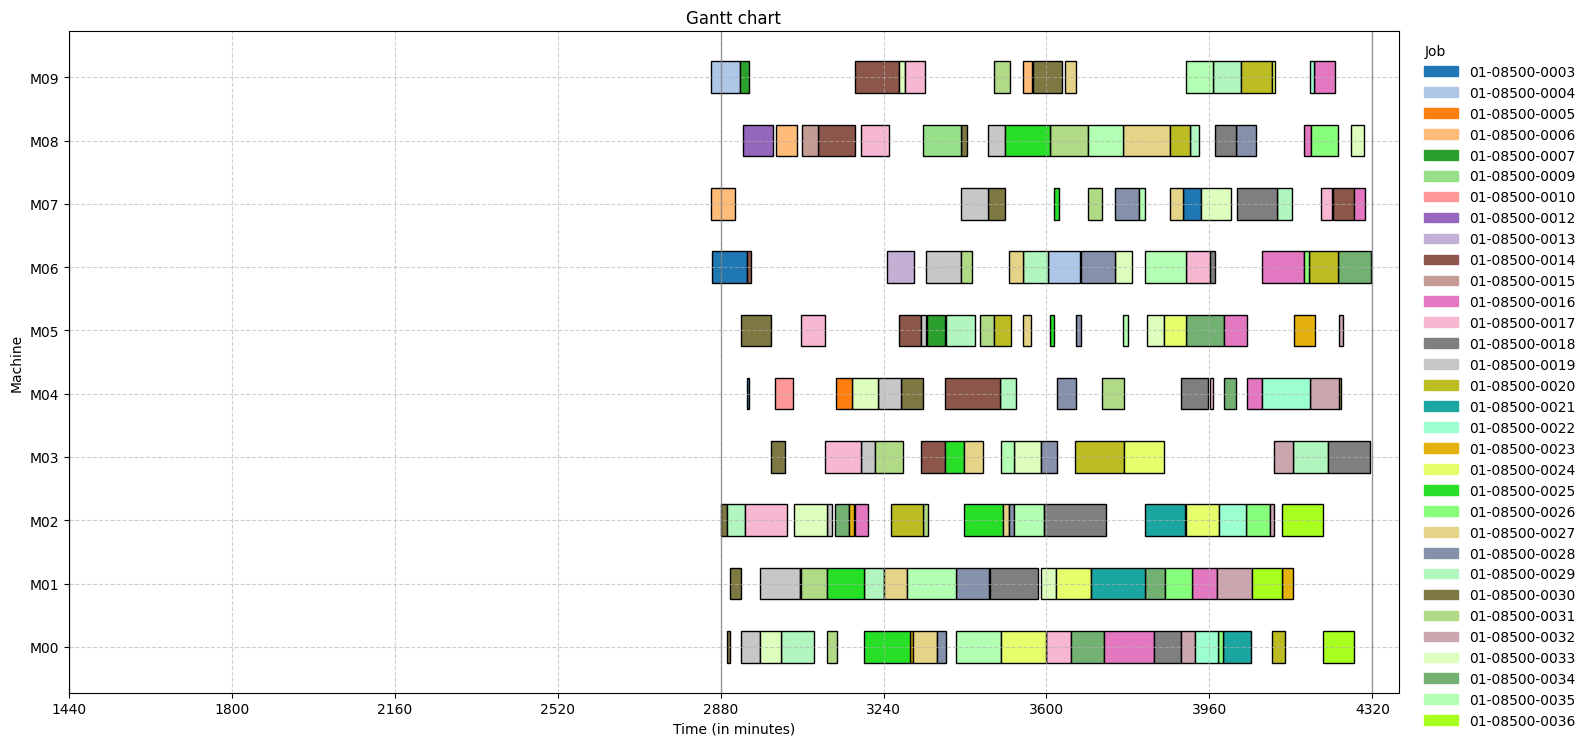

In [42]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution2, perspective="Machine")
plt.show()

#### Check the conditions of the combined data set from the two simulation data sets

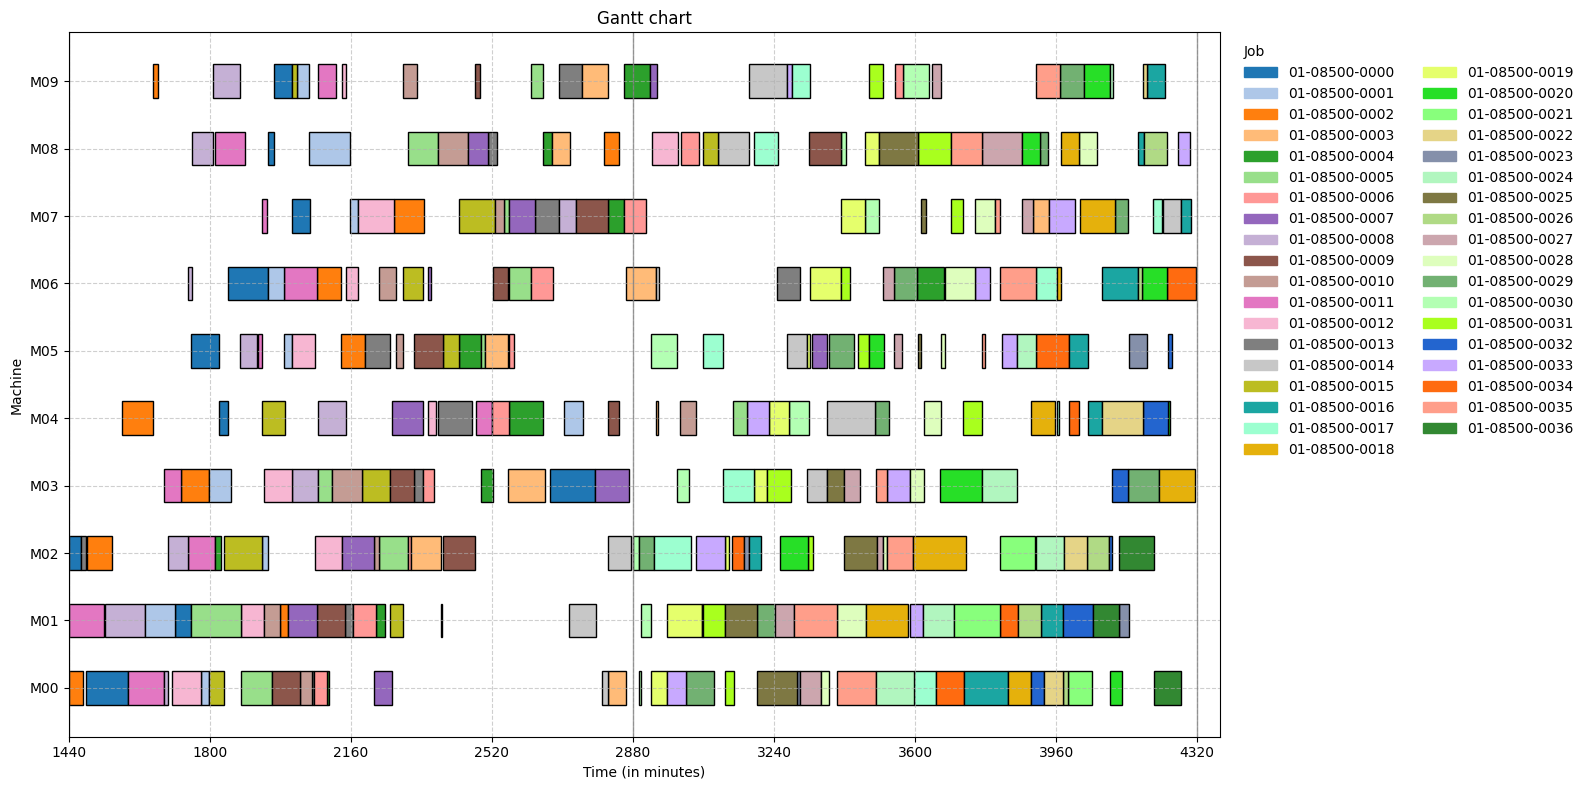

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [43]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)